In [1]:
!pip install zuko

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as data
import zuko

from torch import Tensor
from torch.distributions import Distribution, Normal, Bernoulli, Independent
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image
from tqdm import tqdm

## Prep model

In [3]:
# create deconvolution ELBO 
class Deconvolution_ELBO(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
        likelihood : zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior
        self.likelihood = likelihood
        

    def forward(self, x: Tensor) -> Tensor:
        
        # encode the input
        posterior_context = self.encoder(x)

        # decoder the input
        q = self.decoder(posterior_context)
        latant = q.rsample()
        log_q_z = q.log_prob(latant)
        
        # Compute log prob of latents under the prior.
        log_p_z = self.prior().log_prob(latant)
        
        

        # Compute log prob of the input under the model.
        log_p_x = self.likelihood(latant).log_prob(x)

        # Compute the ELBO as the sum of the log probs.
        elbo = log_p_x + log_p_z - log_q_z
        return elbo


        
    



        

In [4]:
class Deconv_ELBO_2(nn.Module):
    def __init__(
        self,
        encoder: zuko.flows.LazyDistribution,
        decoder: zuko.flows.LazyDistribution,
        prior: zuko.flows.LazyDistribution,
    ):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def forward(self, x: Tensor) -> Tensor:
        q = self.encoder(x)
        z = q.rsample()
        

      
        return self.decoder(z).log_prob(x) + self.prior(x).log_prob(z) - q.log_prob(z)

In [5]:
# decoder and encoder 
class GaussianModel(zuko.flows.LazyDistribution):
    def __init__(self, features: int, context: int):
        super().__init__()
        
        self.hyper = nn.Sequential(
            nn.Linear(context, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2 * features),
        )

    def forward(self, c: Tensor) -> Distribution:
        phi = self.hyper(c)
        
        mu, log_sigma = phi.chunk(2, dim=-1)

        return Independent(Normal(mu, log_sigma.exp()), 1)
    
 



In [6]:
# model 
def train_model(X_train,feature=2, context=60,batch_size=5,model = None ):
    
    trainloader = data.DataLoader(X_train, batch_size=batch_size, shuffle=True)
    elbo = model
    optimizer = torch.optim.Adam(elbo.parameters(), lr=1e-3)

    for epoch in (bar := tqdm(range(20))):
        losses = []

        for x in trainloader:
            
            
            loss = -elbo(x).mean()
            loss.backward()
            

            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.detach())

        losses = torch.stack(losses)

        bar.set_postfix(loss=losses.mean().item())
    return elbo.prior, elbo.encoder

## Test on diferent data 

In [7]:
means = torch.Tensor([
    [0.0, 0.0],
    [2, 3],
    [2, -3]
])
covars = torch.Tensor([
    [
        [0.1, 0],
        [0, 1.5]
    ],
    [
        [1, 0],
        [0, 0.1]
    ],
    [
        [1, 0],
        [0, 0.1]
    ]
])

Z = torch.distributions.MultivariateNormal(loc=means, covariance_matrix=covars).sample((100_000,)).reshape((-1, 2))

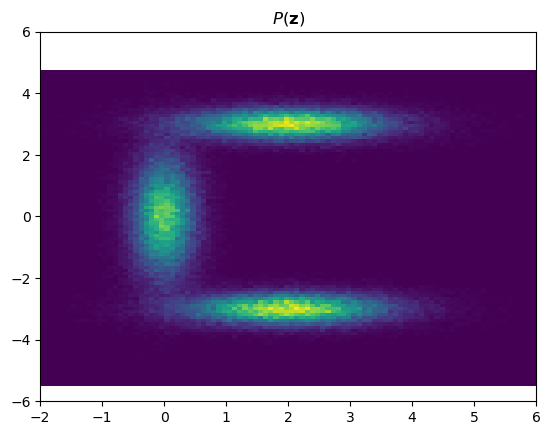

In [8]:
import matplotlib.pyplot as plt
idx = torch.randperm(Z.shape[0])
Z = Z[idx]
Z_train = Z[:Z.shape[0] // 2]
Z_test = Z[Z.shape[0] // 2:]

x_lim = (-2, 6)
y_lim = (-6, 6)

fig, ax = plt.subplots()
plt.hist2d(Z_train[:, 0].numpy(), Z_train[:, 1].numpy(), bins=100) #, ax=ax)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_title(r'$P(\mathbf{z})$');

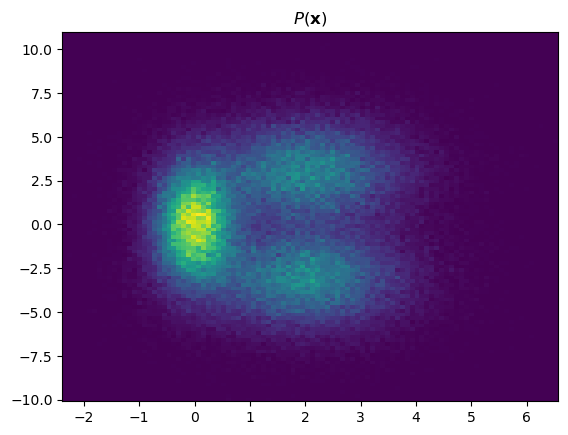

In [9]:
S = torch.Tensor([
    [0.1, 0],
    [0, 3]
])
X = Z + torch.distributions.MultivariateNormal(loc=torch.Tensor([0.0, 0.0]), covariance_matrix=S).sample((Z.shape[0],))
X_train = X[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]

fig, ax = plt.subplots()
plt.hist2d(X_train[:, 0].numpy(), X_train[:, 1].numpy(), bins=100) #, ax=ax

ax.set_title(r'$P(\mathbf{x})$');

In [12]:
from nflows.nn.nets import ResidualNet

encoder = ResidualNet(
    in_features=2,
    out_features=25,
    hidden_features=256,
    num_blocks=3,
    activation=nn.ReLU(),
    dropout_probability=0.0,
)
decoder = zuko.flows.NAF(
    features=2,
    context=25,
    transforms=3,
    hidden_features=(256, 256),
)

prior = zuko.flows.NAF(
    features=2,
    
    transforms=3,
    hidden_features=(256, 256),
)
likelihood = GaussianModel(2,2)


prior,encoder = train_model(torch.tensor(X_train),feature=2, context=60,batch_size=10000,model = Deconvolution_ELBO(encoder,decoder,prior,likelihood))

/var/folders/y6/gpth_0zn2dl4hmv0ss28khb80000gp/T/ipykernel_36824/2952193362.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prior,encoder = train_model(torch.tensor(X_train),feature=2, context=60,batch_size=10000,model = Deconvolution_ELBO(encoder,decoder,prior,likelihood))
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [13:02<00:00, 39.14s/it, loss=4.23]


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10.        ,  -9.87542997,  -9.75085995,  -9.62628992,
         -9.50171989,  -9.37714987,  -9.25257984,  -9.12800982,
         -9.00343979,  -8.87886976,  -8.75429974,  -8.62972971,
         -8.50515968,  -8.38058966,  -8.25601963,  -8.1314496 ,
         -8.00687958,  -7.88230955,  -7.75773952,  -7.6331695 ,
         -7.50859947,  -7.38402945,  -7.25945942,  -7.13488939,
         -7.01031937,  -6.88574934,  -6.76117931,  -6.63660929,
         -6.51203926,  -6.38746923,  -6.26289921,  -6.13832918,
         -6.01375916,  -5.88918913,  -5.7646191 ,  -5.64004908,
         -5.51547905,  -5.39090902,  -5.266339  ,  -5.14176897,
         -5.01719894,  -4.89262892,  -4.76805889,  -4.64348886,
         -4.51891884,  -4.39434881,  -4.2697787

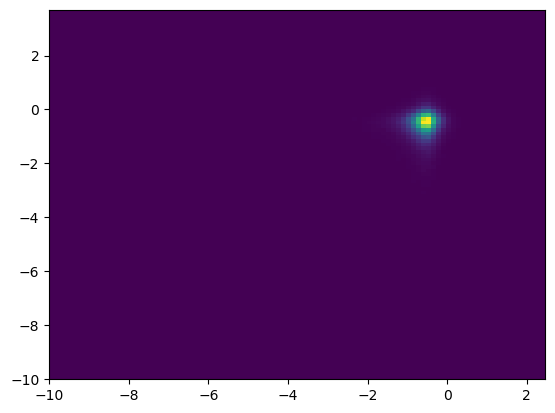

In [13]:
sample = prior().sample((150000,))
# plot the sample
plt.hist2d(sample[:, 0].detach().numpy(), sample[:, 1].detach().numpy(), bins=100)

In [15]:
from nflows.nn.nets import ResidualNet

encoder = GaussianModel(
    features=2,
    context=2,
)
decoder = zuko.flows.NAF(
    features=2,
    context=2,
    transforms=3,
    hidden_features=(256, 256),
)

prior = zuko.flows.NAF(
    features=2,
    context=2,
    transforms=3,
    hidden_features=(256, 256),
)



prior,encoder = train_model(torch.tensor(X_train),feature=2, context=60,batch_size=10000,model = Deconv_ELBO_2(encoder,decoder,prior))

/var/folders/y6/gpth_0zn2dl4hmv0ss28khb80000gp/T/ipykernel_36824/1427142196.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prior,encoder = train_model(torch.tensor(X_train),feature=2, context=60,batch_size=10000,model = Deconv_ELBO_2(encoder,decoder,prior))
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:28<00:00,  7.44s/it, loss=-.95] 


In [16]:
sample = prior(X_train[:10000]).sample((1000,))

plt.hist2d(sample[:, 0].detach().numpy(), sample[:, 1].detach().numpy(), bins=100)
# p

KeyboardInterrupt: 